In [ ]:
#Created by Brady Reynolds

In [ ]:
#You WILL need the following:
#    %pip install numpy pandas matplotlib seaborn scikit-learn shap


# MAKE SURE EVERYTHING IS UP TO DATE IF PREDOWNLOADED!!!


In [39]:
# General things for functions
import numpy as np # Numerical commands
import pandas as pd # Data manipulation

#Visualization tools for plotting
import matplotlib.pyplot as plt 
import seaborn as sns


#Machine learning parts itself
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap


In [58]:
#Importing of the files. Cleaned prior to import.
testAway = pd.read_csv('testDataV3_away.txt')
testHome = pd.read_csv('testDataV3_home.txt')
testY = pd.read_csv('testDataV3_y.txt') # Used to check prediction accuracy. Contains home_win, draw, away_win values

trainAway = pd.read_csv('trainDataV3_away.txt') # Different IDS than test
trainHome = pd.read_csv('trainDataV3_home.txt')
trainY = pd.read_csv('trainDataV3_y.txt') # In training, use this to understand what difference in values leads to a win, draw, loss.

In [59]:
# Rename columns to distinguish home and away stats
trainAway = trainAway.add_prefix("AWAY_")
trainHome = trainHome.add_prefix("HOME_")

# Ensure features match in the correct order for concatenation
selected_features = ['TEAM_SHOTS_TOTAL_season_sum', 'TEAM_SHOTS_ON_TARGET_season_sum',
                     'TEAM_PASSES_season_sum', 'TEAM_SUCCESSFUL_PASSES_season_sum',
                     'TEAM_SAVES_season_sum', 'TEAM_CORNERS_season_sum',
                     'TEAM_FOULS_season_sum', 'TEAM_YELLOWCARDS_season_sum',
                     'TEAM_REDCARDS_season_sum', 'TEAM_ATTACKS_season_sum',
                     'TEAM_DANGEROUS_ATTACKS_season_sum', 'TEAM_GOALS_season_sum']

# Create full feature lists with correct prefixes
away_features = ["AWAY_" + col for col in selected_features]
home_features = ["HOME_" + col for col in selected_features]

# Concatenate home and away features
X_train = pd.concat([trainAway[away_features], trainHome[home_features]], axis=1)

# Define the target variable
y_train = trainY[['HOME_WINS', 'DRAW', 'AWAY_WINS']]

Training Accuracy for HOME_WINS: 0.6341
Validation Accuracy for HOME_WINS: 0.6276


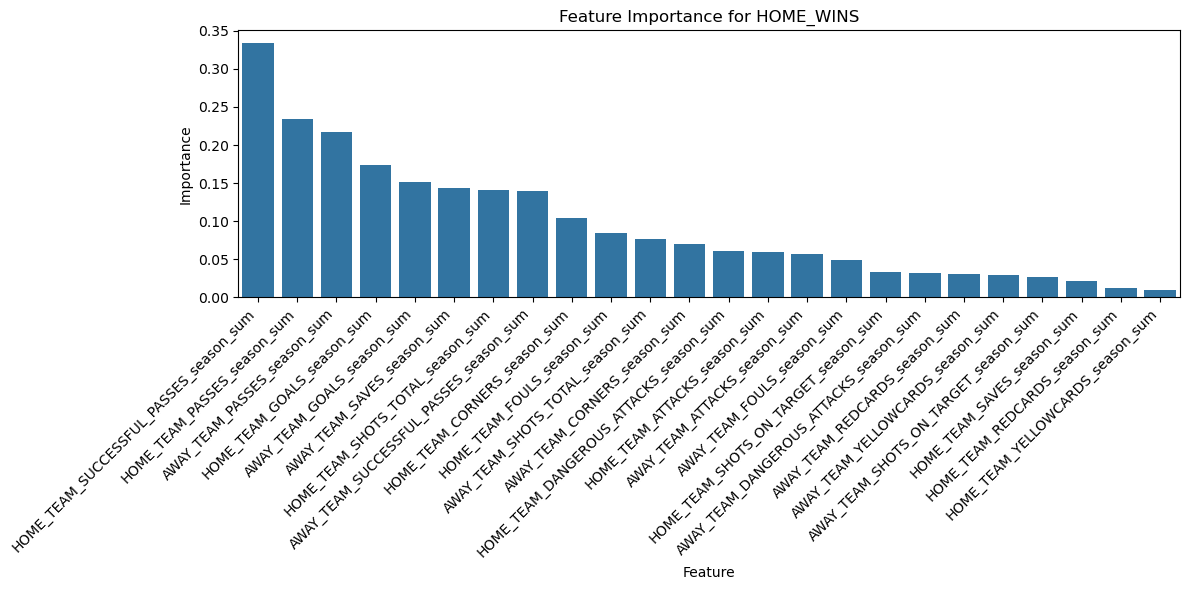

Training Accuracy for DRAW: 0.7411
Validation Accuracy for DRAW: 0.7409


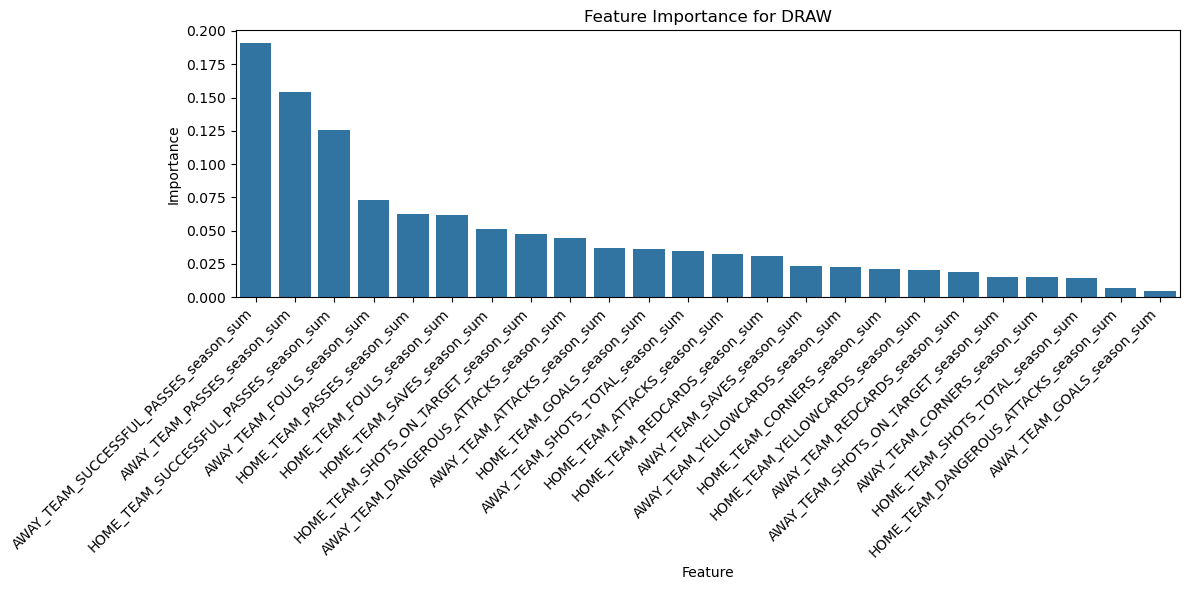

Training Accuracy for AWAY_WINS: 0.7139
Validation Accuracy for AWAY_WINS: 0.7123


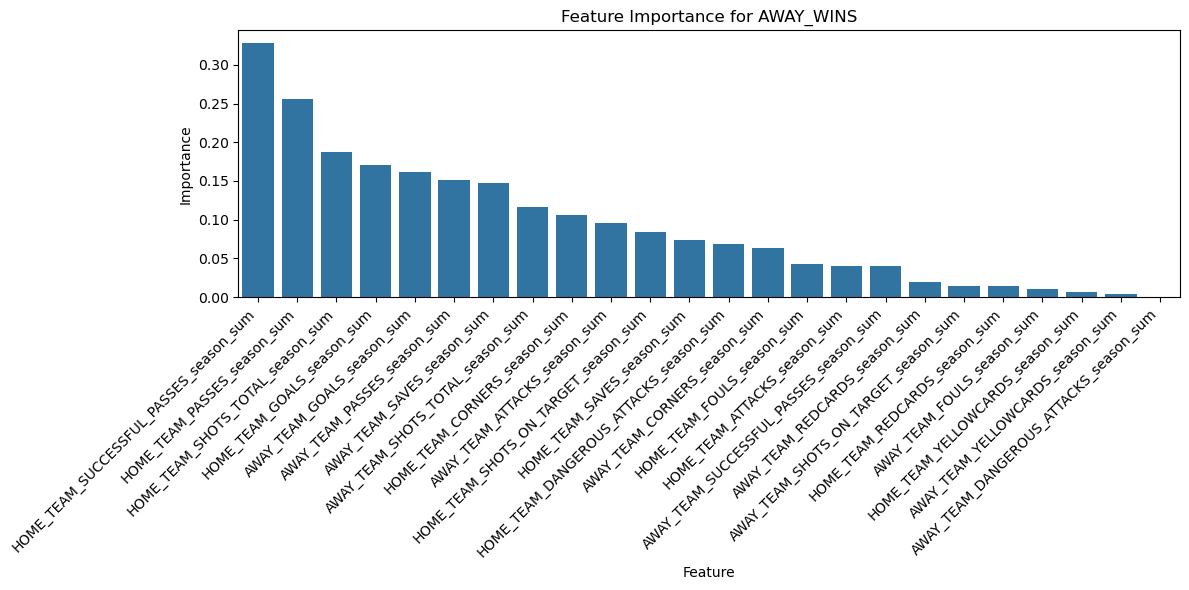

In [24]:
#Logistic Regression
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize a dictionary to store models and their predictions
y_train_pred = {}
y_val_pred = {}

# Train models
for target in y_train.columns:
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train[target])

    # Predict with trainig and validation
    y_train_pred[target] = model.predict(X_train_scaled)
    y_val_pred[target] = model.predict(X_val_scaled)

    train_accuracy = accuracy_score(y_train[target], y_train_pred[target])
    val_accuracy = accuracy_score(y_val[target], y_val_pred[target])

    print(f"Training Accuracy for {target}: {train_accuracy:.4f}")
    print(f"Validation Accuracy for {target}: {val_accuracy:.4f}")

    # Feature importance analysis using coefficients
    importance = np.abs(model.coef_).flatten()
    features = X_train.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importance_df['Feature'], y=importance_df['Importance'])
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance for {target}')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

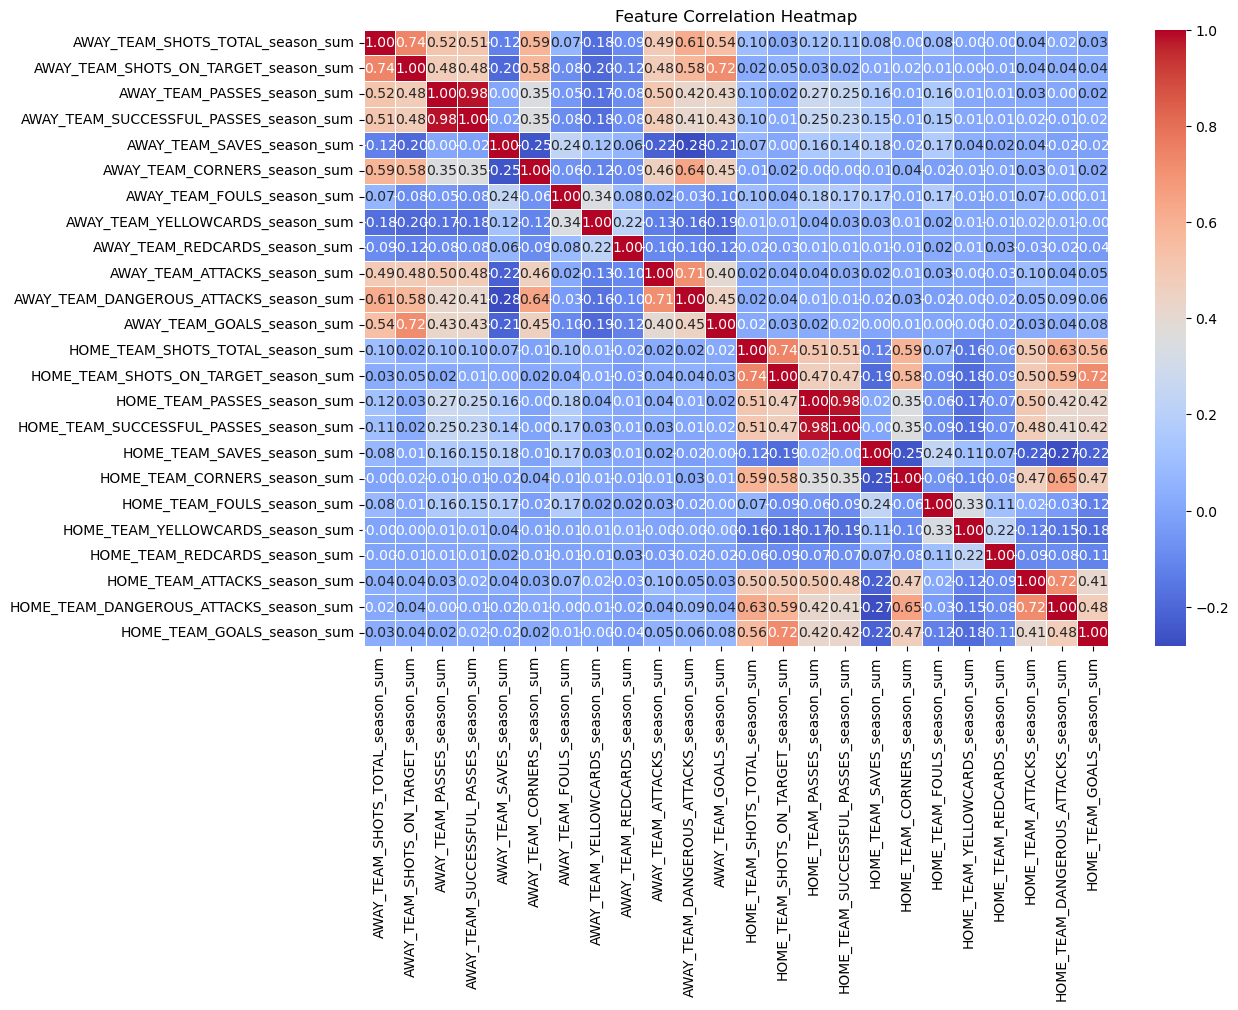

In [ ]:
#Feature correlation heatmap
corr_matrix = pd.DataFrame(X_train_scaled, columns=X_train.columns).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [44]:
# Add prefixes
testAway = testAway.add_prefix("AWAY_")
testHome = testHome.add_prefix("HOME_")
X_test = pd.concat([testAway[away_features], testHome[home_features]], axis=1)
X_test_scaled = scaler.transform(X_test)


Classification Report for HOME_WINS:

              precision    recall  f1-score   support

           0       0.67      0.91      0.77     16621
           1       0.32      0.08      0.13      8242

    accuracy                           0.64     24863
   macro avg       0.49      0.50      0.45     24863
weighted avg       0.55      0.64      0.56     24863

Classification Report for DRAW:

              precision    recall  f1-score   support

           0       0.67      0.92      0.77     16586
           1       0.35      0.09      0.14      8277

    accuracy                           0.64     24863
   macro avg       0.51      0.50      0.46     24863
weighted avg       0.56      0.64      0.56     24863

Classification Report for AWAY_WINS:

              precision    recall  f1-score   support

           0       0.66      0.91      0.77     16519
           1       0.33      0.08      0.13      8344

    accuracy                           0.64     24863
   macro avg       

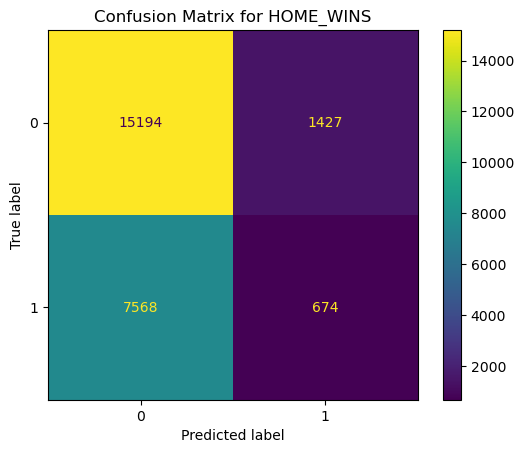

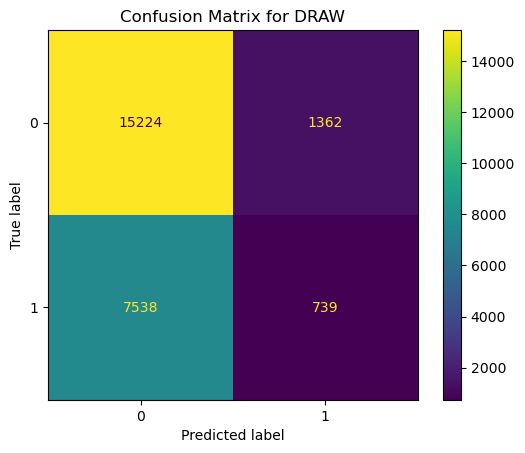

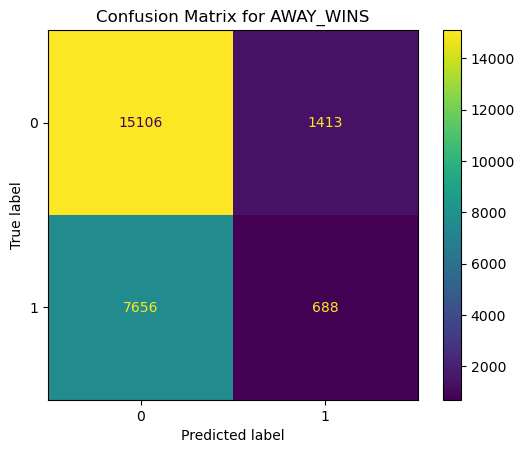

In [ ]:
# Confusion matrix and Classification
y_test_pred = {}
for target in y_train.columns:
    y_test_pred[target] = model.predict(X_test_scaled)
    
for target in y_train.columns:
    print(f"Classification Report for {target}:\n")
    print(classification_report(testY[target], y_test_pred[target]))

for target in y_train.columns:
    cm = confusion_matrix(testY[target], y_test_pred[target])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {target}')
    plt.show()


In [30]:
# Random forest classification
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)
y_val_pred_rf = model_rf.predict(X_val_scaled)

print(classification_report(y_val, y_val_pred_rf))


              precision    recall  f1-score   support

           0       0.58      0.35      0.44       684
           1       0.00      0.00      0.00       407
           2       0.59      0.14      0.23       480

   micro avg       0.58      0.20      0.29      1571
   macro avg       0.39      0.16      0.22      1571
weighted avg       0.43      0.20      0.26      1571
 samples avg       0.20      0.20      0.20      1571



c:\Users\Brady\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


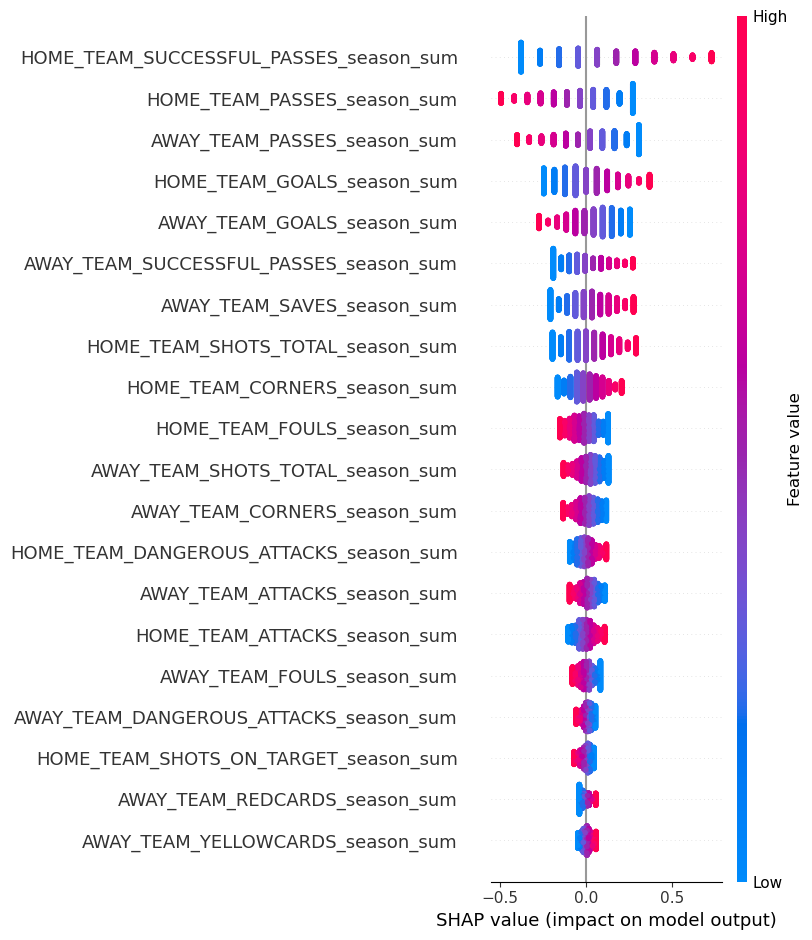

In [40]:
# Shap model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train['HOME_WINS'])

# Ensure that X_train_scaled has the same feature names as your original X_train
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train_scaled)

# Calculate SHAP values for the validation set
shap_values = explainer(X_val_scaled)

# Visualize the feature importance (summary plot)
shap.summary_plot(shap_values, X_val_scaled)

# Visualize the SHAP value for a single prediction (force plot)
shap.initjs()
shap.force_plot(shap_values[0])



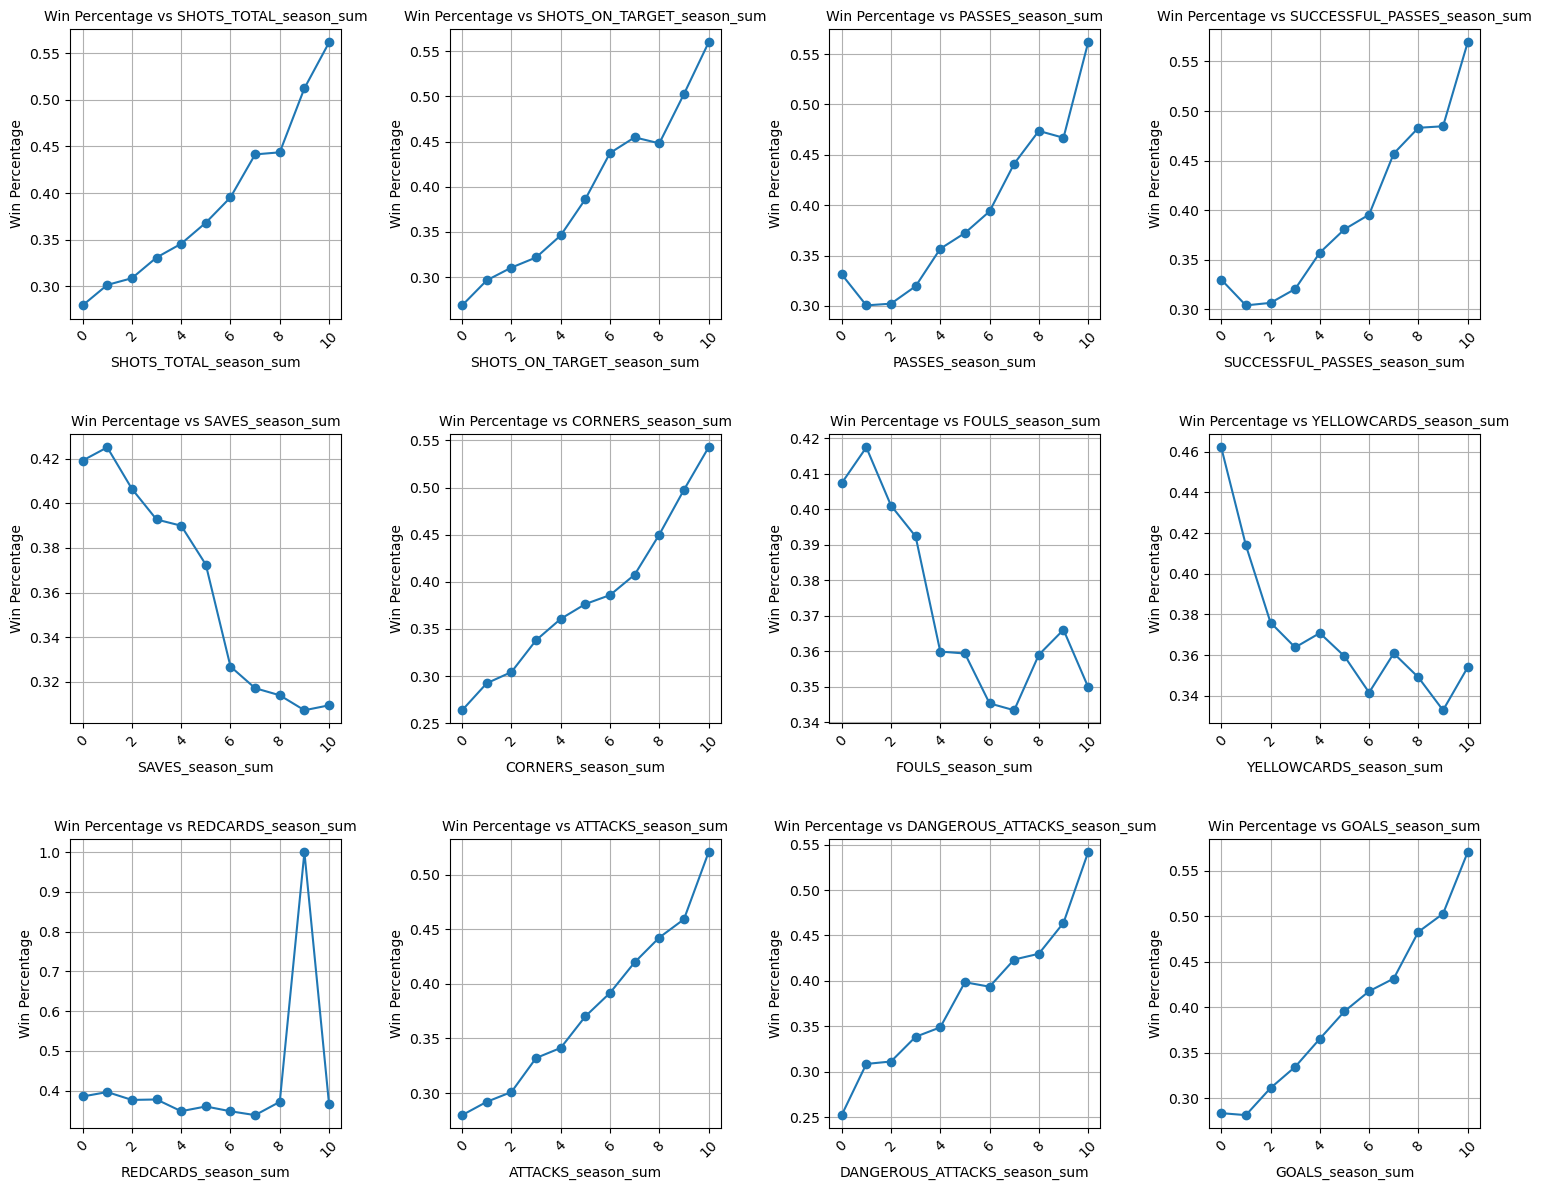

In [66]:
#Mass win vs stat

rows = 3
cols = 4

# Create a figure for subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a list of all stats for mass plotting
for i, feature in enumerate(selected_features):
    # Extract feature data for home and away
    home_stat = trainHome['HOME_' + feature]
    away_stat = trainAway['AWAY_' + feature]

    # Combine the stats from home and away
    combined_stats = pd.concat([home_stat, away_stat], axis=0).reset_index(drop=True)

    # Combine the corresponding win data
    home_wins = trainY['HOME_WINS']
    away_wins = trainY['AWAY_WINS']
    combined_wins = pd.concat([home_wins, away_wins], axis=0).reset_index(drop=True)

    # Create DataFrame for plotting
    win_percentage_data = pd.DataFrame({
        'Stat': combined_stats,
        'Win_Percentage': combined_wins
    })

    # Group by stat and calculate the mean win percentage
    grouped_data = win_percentage_data.groupby('Stat').agg(
        win_percentage=('Win_Percentage', 'mean')
    ).reset_index()

    # Plot on the appropriate subplot
    axes[i].plot(grouped_data['Stat'], grouped_data['win_percentage'], marker='o')
    
    # Use the full feature name for title (removing "TEAM_" prefix)
    short_feature_name = feature.replace('TEAM_', '')  # Removing "TEAM_" from feature name
    
    # Set labels and title
    axes[i].set_xlabel(short_feature_name)
    axes[i].set_ylabel('Win Percentage')
    axes[i].set_title(f'Win Percentage vs {short_feature_name}', fontsize=10)
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Increase spacing between subplots
plt.show()


The below files are to be unused, yet had a previous function prior to better understanding of the desired model.

In [ ]:
# def calculate_game_stats(df):
#     # This will calculate the total number of games played
#     df['TOTAL_GAMES_PLAYED'] = df['TEAM_GAME_WON_season_sum'] + df['TEAM_GAME_DRAW_season_sum'] + df['TEAM_GAME_LOST_season_sum']
    
#     # Calculate Win perctengae: Wins / (total of all games)
#     # This is of course to determine "good" compared to "bad" teams and see what factors are different
#     df['WIN_PERCENTAGE'] = (df['TEAM_GAME_WON_season_sum'] / df['TOTAL_GAMES_PLAYED']) *100
    
#     return df


# trainHome = calculate_game_stats(trainHome)
# trainAway = calculate_game_stats(trainAway)
# testHome = calculate_game_stats(testHome)
# testAway = calculate_game_stats(testAway)


# print("Train Home Data with Stats:")
# print(trainHome[['TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_GAME_LOST_season_sum', 'TOTAL_GAMES_PLAYED', 'WIN_PERCENTAGE']].head())

# print("\nTrain Away Data with Stats:")
# print(trainAway[['TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_GAME_LOST_season_sum', 'TOTAL_GAMES_PLAYED', 'WIN_PERCENTAGE']].head())


# # Below was a simple test to ensure the test data win loss columns were created
# # This is not to be used until model evaluation with the training data

# # print("\nTest Home Data with Stats:")
# # print(testHome[['TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_GAME_LOST_season_sum', 'TOTAL_GAMES_PLAYED', 'WIN_LOSS_RATIO']].head())

# # print("\nTest Away Data with Stats:")
# # print(testAway[['TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_GAME_LOST_season_sum', 'TOTAL_GAMES_PLAYED', 'WIN_LOSS_RATIO']].head())

In [1]:
# def analyze_high_vs_low_winrate(df):
#     # Median win #
#     median_win_percentage = df['WIN_PERCENTAGE'].median()
    
#     # High and low win rate groups (for comparison)
#     high_winrate = df[df['WIN_PERCENTAGE'] >= median_win_percentage]
#     low_winrate = df[df['WIN_PERCENTAGE'] < median_win_percentage]
    
#     # List of statistics to compare
#     stats_to_compare = [
#         'TEAM_SHOTS_TOTAL_season_sum', 'TEAM_SHOTS_ON_TARGET_season_sum',
#         'TEAM_PASSES_season_sum', 'TEAM_SUCCESSFUL_PASSES_season_sum',
#         'TEAM_SAVES_season_sum', 'TEAM_CORNERS_season_sum',
#         'TEAM_FOULS_season_sum', 'TEAM_YELLOWCARDS_season_sum',
#         'TEAM_REDCARDS_season_sum', 'TEAM_ATTACKS_season_sum',
#         'TEAM_DANGEROUS_ATTACKS_season_sum', 'TEAM_GOALS_season_sum'
#     ]
    
#     # Average stats per high/low team
#     high_winrate_stats = high_winrate[stats_to_compare].mean()
#     low_winrate_stats = low_winrate[stats_to_compare].mean()
    
#     # Find the difference to see what matters
#     percentage_diff = ((high_winrate_stats - low_winrate_stats) / low_winrate_stats) * 100
    
#     sorted_diff = percentage_diff.abs().sort_values(ascending=False)

#     print("Top differences between high and low win rate teams:")
#     for stat in sorted_diff.index[:10]:  # Top 10 differences
#         diff = percentage_diff[stat]
#         print(f"{stat}: {diff:.2f}% {'higher' if diff > 0 else 'lower'} for high win rate teams")
    
#     # Shows the top 5 and their average values for comparison
#     top_5_stats = sorted_diff.index[:5]
#     plt.figure(figsize=(12, 6))
#     x = range(len(top_5_stats))
#     plt.bar(x, high_winrate_stats[top_5_stats], width=0.35, align='center', label='High Win Rate')
#     plt.bar(x, low_winrate_stats[top_5_stats], width=0.35, align='edge', label='Low Win Rate')
#     plt.xlabel('Statistics')
#     plt.ylabel('Average Value')
#     plt.title('Top 5 Differences: High vs Low Win Rate Teams')
#     plt.xticks(x, top_5_stats, rotation=45, ha='right')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Run the analysis for both home and away data
# print("Analysis for Home Teams:")
# analyze_high_vs_low_winrate(trainHome)

# print("\nAnalysis for Away Teams:")
# analyze_high_vs_low_winrate(trainAway)


In [3]:
# # Define important features based above
# important_features = [
#     'TEAM_GOALS_season_sum', 'TEAM_SHOTS_ON_TARGET_season_sum', 
#     'TEAM_SUCCESSFUL_PASSES_season_sum', 'TEAM_SHOTS_TOTAL_season_sum',
#     'TEAM_PASSES_season_sum', 'TEAM_DANGEROUS_ATTACKS_season_sum',
#     'TEAM_CORNERS_season_sum', 'TEAM_ATTACKS_season_sum', 'WIN_PERCENTAGE'
# ]

# for feature in important_features:
#     testHome[feature] = pd.to_numeric(testHome[feature], errors='coerce')
#     testAway[feature] = pd.to_numeric(testAway[feature], errors='coerce')

# # Function for comparison and therefore prediction
# def predict_match():
#     # User input
#     home_id = int(input("Enter Home Team ID (12303-37670): "))
#     away_id = int(input("Enter Away Team ID (12303-37670): "))

#     # Ensure ID exists
#     if home_id not in testHome['ID'].values or away_id not in testAway['ID'].values:
#         print("Invalid ID entered. Please try again.")
#         return
    
#     # Gets the team's important stats
#     home_team = testHome[testHome['ID'] == home_id].iloc[0]
#     away_team = testAway[testAway['ID'] == away_id].iloc[0]

#     # Find the difference for comparison
#     comparison = {}
#     for feature in important_features:
#         comparison[f'{feature}_DIFFERENCE'] = home_team[feature] - away_team[feature]

#     print("\nStatistical Comparison (Home - Away):")
#     for feature, diff in comparison.items():
#         print(f"{feature}: {diff:.2f}")

#     # Simple rule-based prediction. Could use tweaking but I need help with that
#     if comparison['WIN_PERCENTAGE_DIFFERENCE'] > 0 and \
#        comparison['TEAM_GOALS_season_sum_DIFFERENCE'] > 0 and \
#        comparison['TEAM_SHOTS_ON_TARGET_season_sum_DIFFERENCE'] > 0:
#         predicted_winner = "Home Team"
#     else:
#         predicted_winner = "Away Team"

#     print(f"\nPredicted Winner: {predicted_winner}")

# predict_match()
